In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pprint
import csv
import ast
import sys


from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

import re

In [4]:
from pandasql import sqldf

In [5]:
### Importer un module de fonctions crée ad hoc
## ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans le même dossier que le présent carnet Jupyter afin que l'importation
#   fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
#sys.path.insert(0, '../..')



import sparql_functions as spqf

In [6]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20240323_093247'

## SPARQL Query

In [7]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [8]:
query = """
SELECT DISTINCT ?item ?itemLabel ?coordinates ?battle_date ?start_time ?end_time
    WHERE {
        {
          {?item wdt:P31 wd:Q178561.
                 OPTIONAL {?item wdt:P625 ?coordinates.
                          ?item wdt:P585 ?battle_date}
                 OPTIONAL {?item wdt:P580 ?start_time;
                            wdt:P582 ?end_time}         
      FILTER(bound(?battle_date))

      # BIND(xsd:integer(REPLACE(str(?battle_date), "(.*)([0-9]{4})(.*)", "$2")) AS ?battle_year)
      
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        }  
      }
    }  
"""

In [9]:
### Execute the SPARQL query
qr = spqf.get_json_sparql_result(endpoint,query)


<class 'dict'>


In [10]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

6434


[['http://www.wikidata.org/entity/Q484475',
  'Battle of Sacheon',
  'Point(128.064194444 35.003805555)',
  '1598-11-11T00:00:00Z',
  '1598-11-06T00:00:00Z',
  '1598-11-11T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q483039',
  'Battle of Inchon',
  'Point(126.63333333 37.48333333)',
  '1950-09-19T00:00:00Z',
  '1950-09-15T00:00:00Z',
  '1950-09-19T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q493122',
  'Battle of Sangju',
  'Point(128.16972222 36.43972222)',
  '1950-01-01T00:00:00Z',
  '1950-07-20T00:00:00Z',
  '1950-07-31T00:00:00Z']]

In [11]:
df_b = pd.DataFrame(r)
df_b.columns = ['uri', 'label', 'geo_coordinates', 'battle_date', 'start_time', 'end_time']
df_b.head()

,uri,label,geo_coordinates,battle_date,start_time,end_time
0,http://www.wikidata.org/entity/Q484475,Battle of Sacheon,Point(128.064194444 35.003805555),1598-11-11T00:00:00Z,1598-11-06T00:00:00Z,1598-11-11T00:00:00Z
1,http://www.wikidata.org/entity/Q483039,Battle of Inchon,Point(126.63333333 37.48333333),1950-09-19T00:00:00Z,1950-09-15T00:00:00Z,1950-09-19T00:00:00Z
2,http://www.wikidata.org/entity/Q493122,Battle of Sangju,Point(128.16972222 36.43972222),1950-01-01T00:00:00Z,1950-07-20T00:00:00Z,1950-07-31T00:00:00Z
3,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z
4,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z


In [12]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6434 entries, 0 to 6433
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              6434 non-null   object
 1   label            6434 non-null   object
 2   geo_coordinates  6434 non-null   object
 3   battle_date      6434 non-null   object
 4   start_time       6434 non-null   object
 5   end_time         6434 non-null   object
dtypes: object(6)
memory usage: 301.7+ KB


In [13]:
### Définir une fonction qui transformer l'année en entier
# avec signe positif si après J.C. ou négatif si avant J.C.
def f1(a):
    if a[0] == '-':
        r = int(a[:5])
    else:
        r = int(a[:4])
    return r     

In [14]:
# Tester la fonction en changeant le signe
f1('-0390-01')

-390

In [15]:
### isoler le premier caractère de la date
bd = df_b.iloc[0]['battle_date']
print(bd, '-> ', bd[0])

1598-11-11T00:00:00Z ->  1


In [16]:
df_b['year'] = df_b[df_b['label'].apply(lambda x : 'Cynoscephalae' in x)].apply(lambda x: f1(x['battle_date']), axis=1)

In [17]:
df_b[df_b['label'].apply(lambda x : 'Cynoscephalae' in x)]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year
1632,http://www.wikidata.org/entity/Q391087,Battle of Cynoscephalae,Point(22.5667 39.4167),-0196-01-01T00:00:00Z,,,-196.0
3211,http://www.wikidata.org/entity/Q2334746,Battle of Cynoscephalae,Point(22.83 39.36),-0363-01-01T00:00:00Z,,,-363.0


In [18]:
df_b['year'] = df_b.apply(lambda x: f1(x['battle_date']), axis=1)

In [19]:
df_b[:3]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year
0,http://www.wikidata.org/entity/Q484475,Battle of Sacheon,Point(128.064194444 35.003805555),1598-11-11T00:00:00Z,1598-11-06T00:00:00Z,1598-11-11T00:00:00Z,1598
1,http://www.wikidata.org/entity/Q483039,Battle of Inchon,Point(126.63333333 37.48333333),1950-09-19T00:00:00Z,1950-09-15T00:00:00Z,1950-09-19T00:00:00Z,1950
2,http://www.wikidata.org/entity/Q493122,Battle of Sangju,Point(128.16972222 36.43972222),1950-01-01T00:00:00Z,1950-07-20T00:00:00Z,1950-07-31T00:00:00Z,1950


In [20]:
### Début de la bataille id = 4
st = df_b.iloc[4]['start_time']
st

'1808-07-24T00:00:00Z'

In [21]:
### Documentation sur l'import et le formatage des dates
# https://stackoverflow.com/questions/127803/how-do-i-parse-an-iso-8601-formatted-date-and-time
# package 'parser' from 'dateutil' library

stt = parser.parse(st)
stt

datetime.datetime(1808, 7, 24, 0, 0, tzinfo=tzutc())

In [22]:
### Fin de la bataille id = 4
et = df_b.iloc[4]['end_time']
ett = parser.parse(et)
et, ett

('1808-08-16T00:00:00Z', datetime.datetime(1808, 8, 16, 0, 0, tzinfo=tzutc()))

In [23]:
duration = ett - stt
days = duration.days
days

23

In [24]:
def get_duration(st, et):
    try:
        stt = parser.parse(st)
        ett = parser.parse(et)
        duration = ett - stt
        days = duration.days + 1
    except:
        days = -1
    return days



In [30]:
get_duration(st, et)

24

In [31]:
df_b['days_duration'] = df_b.apply(lambda x: get_duration(x['start_time'], x['end_time']), axis=1)

In [32]:
df_b[:10].sort_values(by='year', ascending=False)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1,http://www.wikidata.org/entity/Q483039,Battle of Inchon,Point(126.63333333 37.48333333),1950-09-19T00:00:00Z,1950-09-15T00:00:00Z,1950-09-19T00:00:00Z,1950,5
2,http://www.wikidata.org/entity/Q493122,Battle of Sangju,Point(128.16972222 36.43972222),1950-01-01T00:00:00Z,1950-07-20T00:00:00Z,1950-07-31T00:00:00Z,1950,12
5,http://www.wikidata.org/entity/Q383614,Battle of Kohima,Point(94.103175 25.667645),1944-01-01T00:00:00Z,1944-04-04T00:00:00Z,1944-06-22T00:00:00Z,1944,80
7,http://www.wikidata.org/entity/Q327052,Battle of Aachen,Point(6.083333333 50.776388888),1944-10-21T00:00:00Z,1944-10-02T00:00:00Z,1944-10-21T00:00:00Z,1944,20
8,http://www.wikidata.org/entity/Q182530,Battle of Badajoz,Point(-6.96666667 38.86666667),1936-08-14T00:00:00Z,1936-08-12T00:00:00Z,1936-08-14T00:00:00Z,1936,3
4,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z,1808,24
6,http://www.wikidata.org/entity/Q376154,Battle of Copenhagen,Point(12.566666666 55.666666666),1807-01-01T00:00:00Z,1807-08-16T00:00:00Z,1807-09-05T00:00:00Z,1807,21
3,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z,1781,22
9,http://www.wikidata.org/entity/Q94545,Siege of Glatz,Point(16.67 50.433),1760-07-26T00:00:00Z,1760-06-07T00:00:00Z,1760-07-26T00:00:00Z,1760,50
0,http://www.wikidata.org/entity/Q484475,Battle of Sacheon,Point(128.064194444 35.003805555),1598-11-11T00:00:00Z,1598-11-06T00:00:00Z,1598-11-11T00:00:00Z,1598,6


## Détecter les doublons

In [53]:
gb_uri = df_b.groupby('uri').size()
gb_uri.loc[lambda x : x > 1]

uri
http://www.wikidata.org/entity/Q1018969      2
http://www.wikidata.org/entity/Q1028296      2
http://www.wikidata.org/entity/Q104541845    2
http://www.wikidata.org/entity/Q1049530      2
http://www.wikidata.org/entity/Q1066253      2
                                            ..
http://www.wikidata.org/entity/Q944855       2
http://www.wikidata.org/entity/Q964544       2
http://www.wikidata.org/entity/Q9651035      2
http://www.wikidata.org/entity/Q974166       2
http://www.wikidata.org/entity/Q983012       2
Length: 182, dtype: int64

In [54]:
gb_uri.loc[lambda x : x > 1].describe()

count    182.000000
mean       2.098901
std        0.394855
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
dtype: float64

In [55]:
### Effectif et trois instances
len(gb_uri.loc[lambda x : x > 1].index), gb_uri.loc[lambda x : x > 1].index[:3]

(182,
 Index(['http://www.wikidata.org/entity/Q1018969',
        'http://www.wikidata.org/entity/Q1028296',
        'http://www.wikidata.org/entity/Q104541845'],
       dtype='object', name='uri'))

In [56]:
### Les lignes concernées
df_b[df_b.uri.isin(gb_uri.loc[lambda x : x > 1].index)].sort_values(by='uri')

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
191,http://www.wikidata.org/entity/Q1018969,Siege of Van,Point(43.416666666 38.501944444),1915-05-17T00:00:00Z,1915-04-19T00:00:00Z,1915-05-17T00:00:00Z,1915,29
153,http://www.wikidata.org/entity/Q1018969,Siege of Van,Point(43.38 38.494166666),1915-05-17T00:00:00Z,1915-04-19T00:00:00Z,1915-05-17T00:00:00Z,1915,29
250,http://www.wikidata.org/entity/Q1028296,Battle of Grozny,Point(45.7 43.316666666),1994-12-31T00:00:00Z,1994-12-31T00:00:00Z,1995-02-08T00:00:00Z,1994,40
192,http://www.wikidata.org/entity/Q1028296,Battle of Grozny,Point(45.716666666 43.316666666),1994-12-31T00:00:00Z,1994-12-31T00:00:00Z,1995-02-08T00:00:00Z,1994,40
6154,http://www.wikidata.org/entity/Q104541845,Battle of Trocadero,Point(-6.223882151 36.521461599),1823-01-01T00:00:00Z,,,1823,-1
...,...,...,...,...,...,...,...,...
5229,http://www.wikidata.org/entity/Q9651035,Battle of Cerneja,Point(-8.789429 41.694778),1139-01-01T00:00:00Z,,,1139,-1
2409,http://www.wikidata.org/entity/Q974166,Battle of Montenotte,Point(8.276388888 44.398888888),1796-04-12T00:00:00Z,,,1796,-1
2386,http://www.wikidata.org/entity/Q974166,Battle of Montenotte,Point(8.26667 44.4),1796-04-12T00:00:00Z,,,1796,-1
2356,http://www.wikidata.org/entity/Q983012,Ottoman conquest of Adrianople,Point(26.5667 41.6667),1369-01-01T00:00:00Z,,,1369,-1


In [57]:
df_b.sort_values(by='year', ascending=False)[:10]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1376,http://www.wikidata.org/entity/Q121756888,battle of Robotyne,Point(35.833333333 47.45),2023-01-01T00:00:00Z,2023-06-08T00:00:00Z,2023-08-01T00:00:00Z,2023,55
6271,http://www.wikidata.org/entity/Q123014721,Battle of Zikim,Point(34.5037 31.6107),2023-10-01T00:00:00Z,,,2023,-1
6281,http://www.wikidata.org/entity/Q123369926,Battle of Beit Hanoun,Point(34.533333333 31.533333333),2023-01-01T00:00:00Z,,,2023,-1
6242,http://www.wikidata.org/entity/Q123290408,siege of Gaza City,Point(34.466666666 31.5),2023-11-01T00:00:00Z,,,2023,-1
1424,http://www.wikidata.org/entity/Q123302287,Battle of Ofakim,Point(34.616666666 31.316666666),2023-10-01T00:00:00Z,2023-10-07T00:00:00Z,2023-10-09T00:00:00Z,2023,3
6231,http://www.wikidata.org/entity/Q124736376,battle of Djibo,Point(-1.630555555 14.101111111),2023-11-26T00:00:00Z,,,2023,-1
6230,http://www.wikidata.org/entity/Q123058059,Battle of Sufa,Point(34.341388888 31.237222222),2023-10-01T00:00:00Z,,,2023,-1
1337,http://www.wikidata.org/entity/Q112114966,Battle of Lysychansk,Point(38.416666666 48.916666666),2022-01-01T00:00:00Z,2022-02-26T00:00:00Z,2022-07-03T00:00:00Z,2022,128
1354,http://www.wikidata.org/entity/Q111012552,Snake Island campaign,Point(30.204166666 45.255),2022-02-24T00:00:00Z,2022-02-24T00:00:00Z,2022-02-24T00:00:00Z,2022,1
6177,http://www.wikidata.org/entity/Q113111947,Battle of Siversk,Point(38.083333333 48.866666666),2022-01-01T00:00:00Z,,,2022,-1


In [58]:
df_b.describe()

,year,days_duration
count,6434.000000,6434.000000
mean,1589.108175,10.703140
std,533.870698,111.701069
min,-1500.000000,-3652.000000
25%,1517.250000,-1.000000
50%,1799.000000,-1.000000
75%,1904.000000,-1.000000
max,2023.000000,3391.000000


In [59]:
df_b[df_b.days_duration == -1]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
1429,http://www.wikidata.org/entity/Q155302,Battle of Loigny-Poupry,Point(1.73389 48.1239),1870-12-02T00:00:00Z,,,1870,-1
1430,http://www.wikidata.org/entity/Q131969,Battle of Thermopylae,Point(22.536944444 38.795833333),-0479-08-06T00:00:00Z,,,-479,-1
1431,http://www.wikidata.org/entity/Q201692,Battle of Poitiers,Point(0.39 46.54),1356-09-19T00:00:00Z,,,1356,-1
1432,http://www.wikidata.org/entity/Q201692,Battle of Poitiers,Point(0.39 46.54),1356-09-17T00:00:00Z,,,1356,-1
1433,http://www.wikidata.org/entity/Q139808,Battle of the Catalaunian Plains,Point(4.5 49.0),0451-06-21T00:00:00Z,,,451,-1
...,...,...,...,...,...,...,...,...
6296,http://www.wikidata.org/entity/Q121853731,Battle of Bagar,Point(75.5 28.18),1192-09-01T00:00:00Z,,,1192,-1
6297,http://www.wikidata.org/entity/Q48202,Battle of Custoza,Point(10.79583333 45.37888889),1848-07-25T00:00:00Z,,,1848,-1
6298,http://www.wikidata.org/entity/Q124827387,Q124827387,Point(25.298935 43.156826944),1868-07-09T00:00:00Z,,,1868,-1
6299,http://www.wikidata.org/entity/Q25544,Battle of the Dardanelles,Point(26.158011111 40.012591666),1807-01-01T00:00:00Z,,,1807,-1


In [60]:
df_b[df_b.days_duration > 100].describe()

,year,days_duration
count,156.000000,156.000000
mean,1734.038462,354.397436
std,307.026192,548.795451
min,617.000000,101.000000
25%,1601.500000,128.750000
50%,1893.500000,182.000000
75%,1943.000000,358.000000
max,2022.000000,3391.000000


In [61]:
len(df_b[df_b.days_duration > 152])

91

<Axes: >

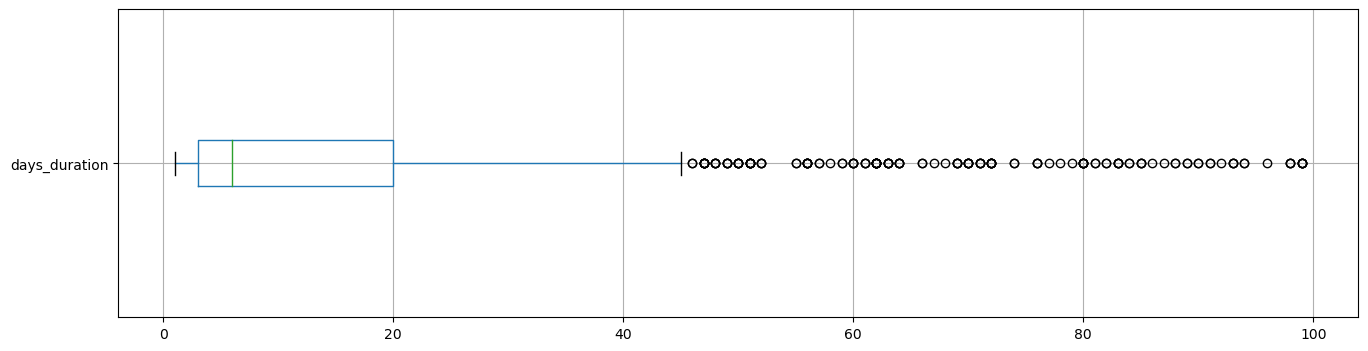

In [62]:
### Diagramme-boîte ou boîte-à-moustache pour représenter la dispersion
# Ligne centrale = la médiane. Le box est entre 1er et 3e quartile
# La moitié de la population se situe entre 31 et 68 ans
#  Noter qu'on utilise le DataFrame car cet objet dispose d'une méthode boxplot
# ce qui n'est pas le cas d'une série (pd.Series)
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)] .boxplot(column=['days_duration'], vert=False, figsize=(16,4))

In [63]:
df_b[(df_b.days_duration > 0) & (df_b.days_duration < 100)].days_duration.describe()

count    1401.000000
mean       15.995004
std        21.179622
min         1.000000
25%         3.000000
50%         6.000000
75%        20.000000
max        99.000000
Name: days_duration, dtype: float64

In [64]:
years_count = pd.DataFrame(df_b.groupby('year').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,-1500,1
1,-1456,1
2,-1324,1
3,-1273,1
4,-1249,1
...,...,...
1283,2019,8
1284,2020,15
1285,2021,6
1286,2022,20


In [65]:
years_count.effectif.max()

122

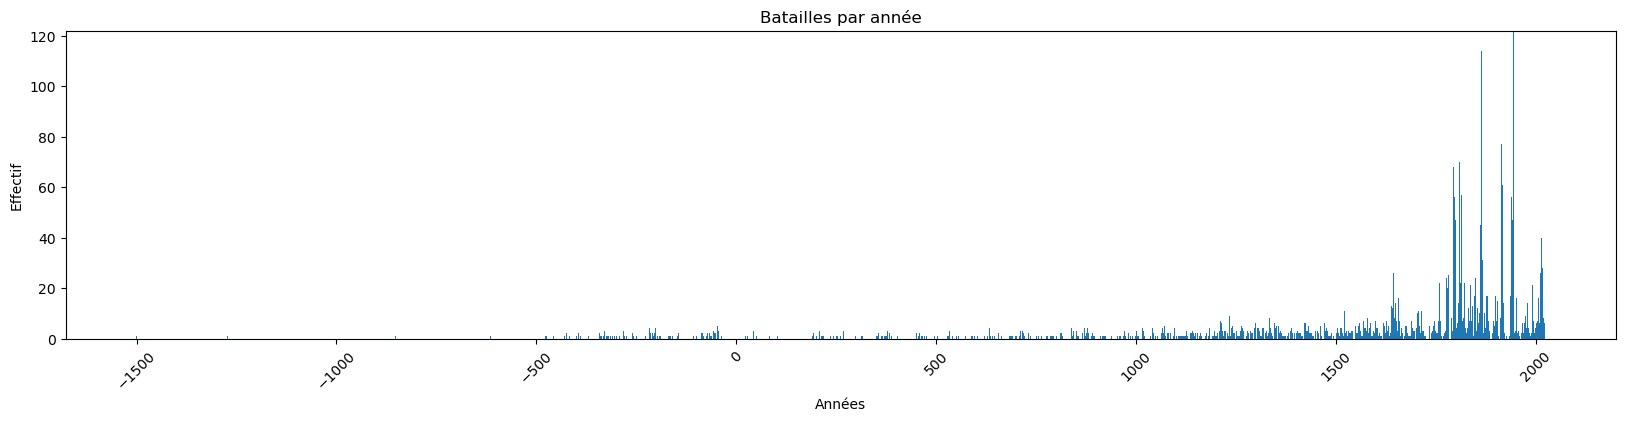

In [72]:
# Effectifs par année

objects = years_count['year']
eff = years_count['effectif']


p1 = plt.bar(objects, eff, width=1)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(20,4)
plt.ylim(0,max(eff))
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

In [73]:
# Effectifs par année

objects = years_count['year']
eff = years_count['effectif']

years_between = years_count[(years_count.year >1000) & (years_count.year < 1200) ]

print(years_between.head())

     year  effectif
440  1001         3
441  1003         1
442  1004         1
443  1006         1
444  1009         1


In [74]:
years_between.plot(kind='bar', x='year', figsize=(20,4), rot=45, fontsize=6)

<Axes: xlabel='year'>

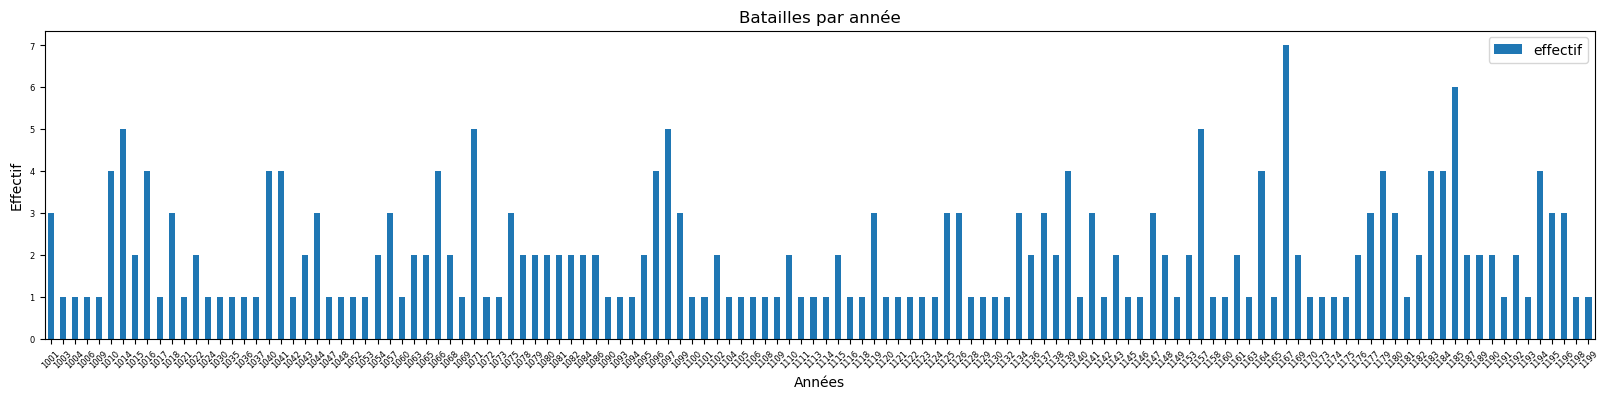

In [75]:
objects = years_between['year']
eff = years_between['effectif']


p1 = plt.bar(objects, eff, width=0.5)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(20,4)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

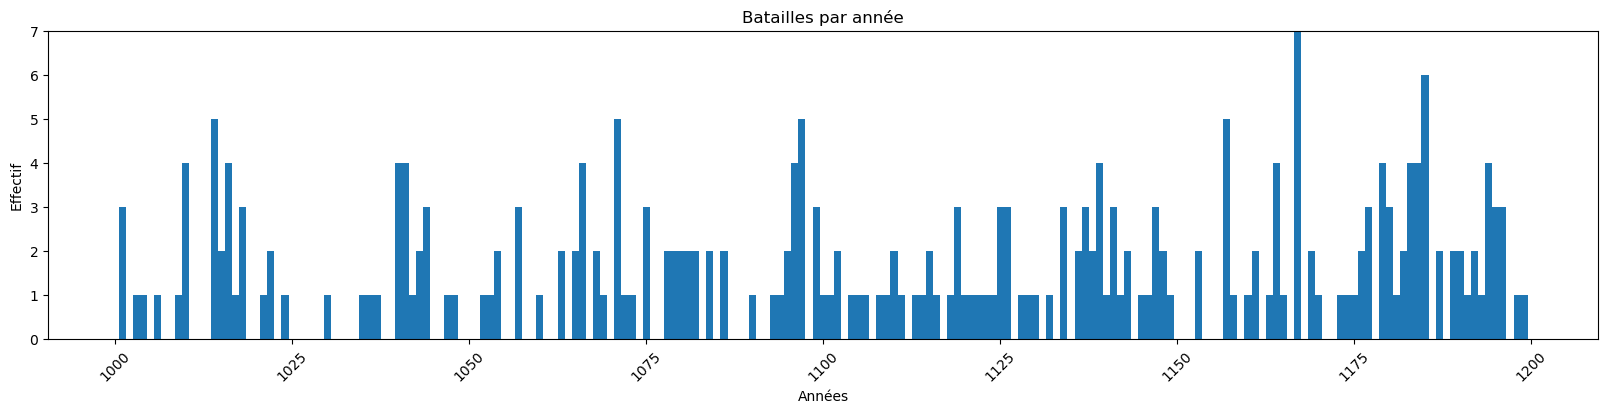

In [84]:
# Effectifs par année

objects = years_between['year']
eff = years_between['effectif']



p1 = plt.bar(objects, eff, width=1)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par année')
plt.gcf().set_size_inches(20,4)
plt.ylim(0,max(eff))
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()

## Regrouper par périodes de cinquante ans

In [85]:
l_50 = list(range(1001, 2052, 50))
l_50[:5],l_50[-5:]

([1001, 1051, 1101, 1151, 1201], [1851, 1901, 1951, 2001, 2051])

In [86]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_b = df_b.copy(deep=True)

In [87]:
cdf_b.head()

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration
0,http://www.wikidata.org/entity/Q484475,Battle of Sacheon,Point(128.064194444 35.003805555),1598-11-11T00:00:00Z,1598-11-06T00:00:00Z,1598-11-11T00:00:00Z,1598,6
1,http://www.wikidata.org/entity/Q483039,Battle of Inchon,Point(126.63333333 37.48333333),1950-09-19T00:00:00Z,1950-09-15T00:00:00Z,1950-09-19T00:00:00Z,1950,5
2,http://www.wikidata.org/entity/Q493122,Battle of Sangju,Point(128.16972222 36.43972222),1950-01-01T00:00:00Z,1950-07-20T00:00:00Z,1950-07-31T00:00:00Z,1950,12
3,http://www.wikidata.org/entity/Q459447,Siege of Yorktown,Point(-76.5025 37.230833333),1781-01-01T00:00:00Z,1781-09-28T00:00:00Z,1781-10-19T00:00:00Z,1781,22
4,http://www.wikidata.org/entity/Q326115,Second Siege of Gerona,Point(2.816666666 41.983333333),1808-08-16T00:00:00Z,1808-07-24T00:00:00Z,1808-08-16T00:00:00Z,1808,24


#### Codage de domaine

In [88]:

## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html


cdf_b['periodes'] = pd.cut(cdf_b['year'], l_50, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_b['periodes'] = cdf_b['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_b.head(3)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
0,http://www.wikidata.org/entity/Q484475,Battle of Sacheon,Point(128.064194444 35.003805555),1598-11-11T00:00:00Z,1598-11-06T00:00:00Z,1598-11-11T00:00:00Z,1598,6,1551-1600
1,http://www.wikidata.org/entity/Q483039,Battle of Inchon,Point(126.63333333 37.48333333),1950-09-19T00:00:00Z,1950-09-15T00:00:00Z,1950-09-19T00:00:00Z,1950,5,1901-1950
2,http://www.wikidata.org/entity/Q493122,Battle of Sangju,Point(128.16972222 36.43972222),1950-01-01T00:00:00Z,1950-07-20T00:00:00Z,1950-07-31T00:00:00Z,1950,12,1901-1950


In [89]:
cdf_b[cdf_b.year == 2015][:3]

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
1370,http://www.wikidata.org/entity/Q20984822,2015 Fotokol attack,Point(14.230555555 12.3775),2015-02-01T00:00:00Z,2015-02-04T00:00:00Z,2015-02-05T00:00:00Z,2015,2,2001-2050
1384,http://www.wikidata.org/entity/Q19926256,Palmyra Offensive,Point(38.267222222 34.56),2015-05-26T00:00:00Z,2015-05-13T00:00:00Z,2015-05-25T00:00:00Z,2015,13,2001-2050
1386,http://www.wikidata.org/entity/Q20241081,Al-Hasakah city offensive (June 2015),Point(40.75 36.483333333),2015-08-01T00:00:00Z,2015-06-23T00:00:00Z,2015-08-01T00:00:00Z,2015,40,2001-2050


In [90]:
### Regrouper et compter par génération avec la fonction Pandas 'groupby' (équivalente à la précédente)
# Pertinent en fonction de critères de domaine liés à l'âge
gb_cdf_b = pd.DataFrame(cdf_b.groupby('periodes').size())
gb_cdf_b.columns = ['effectif']
gb_cdf_b.tail()

,effectif
periodes,
1801-1850,755
1851-1900,775
1901-1950,1044
1951-2000,263
2001-2050,329


In [91]:
gb_cdf_bi = [l for l in gb_cdf_b.index]
eff = [l for l in gb_cdf_b['effectif']]
nom = 'Effectifs'

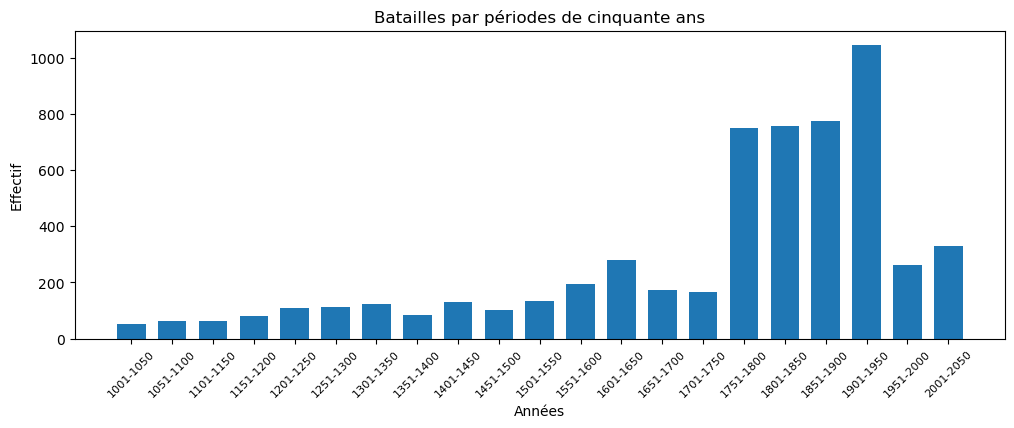

In [92]:

p1 = plt.bar(gb_cdf_bi, eff, width=0.7)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Batailles par périodes de cinquante ans')
plt.gcf().set_size_inches(12,4)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45, size=8)
plt.show()

### Afficher les durées 

In [93]:
cdf_b.head(3)

,uri,label,geo_coordinates,battle_date,start_time,end_time,year,days_duration,periodes
0,http://www.wikidata.org/entity/Q484475,Battle of Sacheon,Point(128.064194444 35.003805555),1598-11-11T00:00:00Z,1598-11-06T00:00:00Z,1598-11-11T00:00:00Z,1598,6,1551-1600
1,http://www.wikidata.org/entity/Q483039,Battle of Inchon,Point(126.63333333 37.48333333),1950-09-19T00:00:00Z,1950-09-15T00:00:00Z,1950-09-19T00:00:00Z,1950,5,1901-1950
2,http://www.wikidata.org/entity/Q493122,Battle of Sangju,Point(128.16972222 36.43972222),1950-01-01T00:00:00Z,1950-07-20T00:00:00Z,1950-07-31T00:00:00Z,1950,12,1901-1950


In [94]:
df_cdf_b = pd.DataFrame(cdf_b[['label', 'year', 'days_duration' ]][cdf_b['days_duration'] > 1000])
#df_cdf_b.columns=['lustre', 'femmes']
df_cdf_b.head()

,label,year,days_duration
330,Battle of the Frontiers,1914,1864
339,Battle of Fuentes de Oñoro,1811,1450
634,Battle of Anjō,1540,3289
648,Battle of Aleppo,2016,1618
882,Siege of Bursa,1326,3391


In [ ]:
df_b[df_b.days_duration == -1]